In [4]:
%pylab inline
from siph import *



import h5py
import condor

Populating the interactive namespace from numpy and matplotlib


/Users/hantke/Library/Python/2.7/lib/python/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [259]:
photon_energy_correction = 1.0

def read_data(experiment, run_number, N=50, skip=1):
    print photon_energy_correction
    filename = "/Users/hantke/davinci/scratch/fhgfs/xray/%s/preproc/%s_r%04i_ol3.h5" % (experiment,experiment,run_number)
    with h5py.File(filename, "r") as f:
        imgs = asarray(f["entry_1/data_1/data"][-N-skip:-skip])
        msk = asarray(f["entry_1/data_1/mask"])
        gains = asarray(f["entry_1/detector_1/gain"][-N-skip:-skip]) * photon_energy_correction
        photon_energies_SLAC = asarray(f["entry_1/FEL/photon_energy_eV_SLAC"][-N-skip:-skip]) * photon_energy_correction
        gmds = asarray(f["entry_1/detector_3/pulse_energy_mJ"][-N-skip:-skip]) 
    print gmds[0]
    return imgs, msk, gains, photon_energies_SLAC, gmds

def generate_mask(msk, rlims=None):
    tmp = (msk&condor.utils.pixelmask.PixelMask.PIXEL_IS_IN_MASK)==0
    tmp[:512,512:] = False
    if rlims is not None:
        X, Y = meshgrid(arange(msk.shape[1]), arange(msk.shape[0]))
        R = sqrt((X-530)**2 + (Y-550)**2)
        tmp *= (R >= rlims[0])*(R <= rlims[1])
    return tmp
        
def apply_mask(imgs, msk, rlims=None):
    tmp = repeat(asarray([msk]), imgs.shape[0], axis=0)
    values = imgs.flatten()[tmp.flatten()]
    return values
    

In [ ]:
nbins = 101
ex = "amol3416"
N = 10
vmin = -0.5
vmax = 1.5

# No gas
r = 154
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
msk = generate_mask(msk)
values = apply_mask(imgs, msk, rlims=(50, 300))
print gains.mean()
photons = values / gains.mean()
I_no, H_no = histogram(photons, nbins=nbins, vmin=vmin, vmax=vmax)

# Only N2
r = 152
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
msk = generate_mask(msk)
values = apply_mask(imgs, msk)#, rlims=(50, 300))
photons = values / gains.mean()
I_N2, H_N2 = histogram(photons, nbins=nbins, vmin=vmin, vmax=vmax)

In [284]:
wl_O_Kalpha = 2.362E-9
wl_N_Kalpha = 3.16E-9
wl_C_Kalpha = 4.47E-9
EeV_O_Kalpha = condor.source.Photon(wavelength=wl_O_Kalpha).get_energy_eV()
EeV_N_Kalpha = condor.source.Photon(wavelength=wl_N_Kalpha).get_energy_eV()
EeV_C_Kalpha = condor.source.Photon(wavelength=wl_C_Kalpha).get_energy_eV()
EeV_photon = np.median(photon_energies_SLAC)
photon_energy0 = 1.
photon_energyO = EeV_O_Kalpha/EeV_photon
photon_energyN = EeV_N_Kalpha/EeV_photon
photon_energyC = EeV_C_Kalpha/EeV_photon

(0, 10000)

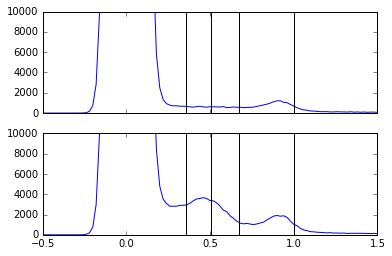

In [285]:
fig, axs = subplots(2, 1, sharey=True, sharex=True)
axs[0].plot(I_no, H_no)
axs[1].plot(I_N2, H_N2)
for ax in axs:
    ax.axvline(photon_energyC, color='black')
    ax.axvline(photon_energyN, color='black')
    ax.axvline(photon_energyO, color='black')
    ax.axvline(photon_energy0, color='black')    
ylim(0, 10000)

In [273]:
def hist_I_N(N, sigma, L, nphotons_list, noise_sigma=None, nbins=101, photon_energy=1.0, vmin=-0.5, vmax=1.5):
    H = 0.
    for i,nphotons in enumerate(nphotons_list):
        I, h = hist_I(sigma, L, nphotons, noise_sigma, nbins, photon_energy*(i+1), vmin, vmax)
        H = H + h
    return I, H

def fit_hist_no(I, H, S, sigma0=0.2, L0=3, noise_sigma0=0.1, photon_energy=1.0, N=1):
    assert len(I) == len(H)
    nbins = len(I)
    nphotons0 = H.sum()

    # 1) Simple Gaussian fit for getting good estimate for noise_sigma
    S0 = I <= 0.25
    func = lambda noise_sigma: 1-scipy.stats.pearsonr(np.exp(-I[S0]**2/(2.*noise_sigma0**2)), H[S0])[0]
    noise_sigma_fit = scipy.optimize.leastsq(func, noise_sigma0)[0][0]
    # 2) Now fit of the other variables
    x0 = [sigma0, L0]
    for i in range(N):
        x0 += [nphotons0/N]
    #func1 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S]
    #func2 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S]
    #func = lambda x: func1(x)/func2(x)
    
    func = lambda x: ((hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S])
#                      (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
#                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S])
    assert np.isnan(func(x0).any()) == False
    x_fit = scipy.optimize.leastsq(func, x0,
                                   args=(), Dfun=None,
                                   full_output=0, col_deriv=0,
                                   ftol=1.49012e-08, xtol=1.49012e-08, gtol=0.0, 
                                   maxfev=0, epsfcn=None, factor=100, diag=None)[0]
    sigma_fit = x_fit[0]
    L_fit = x_fit[1]
    nphotons_fit_list = list(x_fit[2:])
    return sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit

def fit_hist_N2(I, H, S, nphotons10, nphotonsN0, sigma, L, noise_sigma, photon_energy=1.0, N=1):
    assert len(I) == len(H)
    nbins = len(I)

    x0 = []
    for i in range(N):
        x0 += [nphotons10/N]
    for i in range(N):
        x0 += [nphotonsN0/N]
    _hist_I_N = lambda nphotons_list, photon_energy: hist_I_N(N, sigma=sigma, L=L, nphotons_list=nphotons_list, noise_sigma=noise_sigma,
                                                               nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])
    hist_I_N_0 = lambda nphotons_list: _hist_I_N(nphotons_list, photon_energy)
    hist_I_N_N = lambda nphotons_list: _hist_I_N(nphotons_list, photon_energyN)
   
    hist_model = lambda x: abs(hist_I_N_0(x[:N])[1]) + abs(hist_I_N_N(x[N:])[1])
    func = lambda x: ((hist_model(x) - H)/abs(hist_model(x)+ H))[S]
    assert np.isnan(func(x0).any()) == False
    x_fit = scipy.optimize.leastsq(func, x0,
                                   args=(), Dfun=None,
                                   full_output=0, col_deriv=0,
                                   ftol=1.49012e-08, xtol=1.49012e-08, gtol=0.0, 
                                   maxfev=0, epsfcn=None, factor=100, diag=None)[0]
    nphotons0_fit_list = list(x_fit[:N])
    nphotonsN_fit_list = list(x_fit[N:])
    print nphotons0_fit_list, nphotonsN_fit_list
    return nphotons0_fit_list, nphotonsN_fit_list


In [289]:
def fit_and_plot_no_gas(I, H, S, sigma0=0.2, L0=20, noise_sigma0=0.05, N=2):
    sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit = fit_hist_no(I, H, S,
                                                                      sigma0=sigma0, L0=L0, 
                                                                      noise_sigma0=noise_sigma0, N=N)
    H_sum_fit = 0
    for i, nphotons_i_fit in enumerate(nphotons_fit_list):
        Ii_fit, Hi_fit = hist_I(sigma_fit, L_fit, abs(nphotons_i_fit), noise_sigma=noise_sigma_fit, nbins=nbins,
                                photon_energy=1.+i, vmin=I[0], vmax=I[-1])
        H_sum_fit = H_sum_fit + Hi_fit
        plot(Ii_fit, Hi_fit, "--", color="black")

    semilogy(Ii_fit, H_sum_fit, color="red")
    semilogy(I, H)
    ylim(10, 40000000)
    return sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit

def fit_and_plot_N2(I, H, S, sigma_fit, L0, nphotons10, nphotonsN20, noise_sigma0): 
    hist_I_1 = lambda L, nphotons, noise_sigma: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma,
                                                       nbins=nbins, photon_energy=1.0)[1]
    hist_I_N = lambda L, nphotons, noise_sigma: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma,
                                                       nbins=nbins, photon_energy=photon_energyN)[1]
    #hist_I_C = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
    #                                             nbins=nbins, photon_energy=photon_energyC)[1]
    #hist_I_O = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
    #                                             nbins=nbins, photon_energy=photon_energyO)[1]
    #H_sum = lambda L, nphotons1, nphotonsN, nphotonsC, nphotonsO: hist_I_1(abs(L), abs(nphotons1)) +\
    #                                                              hist_I_N(abs(L), abs(nphotonsN)) +\
    #                                                              hist_I_C(abs(L), abs(nphotonsC)) +\
    #                                                              hist_I_O(abs(L), abs(nphotonsO))
    H_sum = lambda L, nphotons1, nphotonsN, noise_sigma: hist_I_1(abs(L), abs(nphotons1), abs(noise_sigma)) +\
                                                         hist_I_N(abs(L), abs(nphotonsN), abs(noise_sigma))
    func = lambda x: ((H - H_sum(x[0], x[1], x[2], x[3]))/(H + H_sum(x[0], x[1], x[2], x[3])))[S]
    x = scipy.optimize.leastsq(func, [L0, nphotons10, nphotonsN20, noise_sigma0])[0]
    x = abs(array(x))
    [L_fit, nphotons1_fit, nphotonsN_fit, noise_sigma_fit] = x
    
    H_1 = hist_I_1(L_fit, nphotons1_fit, noise_sigma_fit)
    H_N = hist_I_N(L_fit, nphotonsN_fit, noise_sigma_fit)
    #H_C = hist_I_C(L_fit2, nphotonsC_fit)
    #H_O = hist_I_O(L_fit2, nphotonsO_fit)
    plot(I, H_1, "--", c='red')
    plot(I, H_N, "--", c='red')
    #plot(I, H_C, "--", c='red')
    #plot(I, H_O, "--", c='red')
    #plot(I, H_1+H_N+H_C+H_O)
    plot(I, H_1+H_N)
    plot(I, H, ".", c="black")
    ylim(0, 10000)
    
    return L_fit, nphotons1_fit, nphotonsN_fit, noise_sigma_fit

def fit_and_plot_N2(I, H, S, sigma, L, nphotons00, nphotonsN0, noise_sigma, photon_energy=1., N=1): 
    nphotons0_list_fit, nphotonsN_list_fit = fit_hist_N2(I, H, S, nphotons00, nphotonsN0, sigma, L, noise_sigma, photon_energy=photon_energy, N=N)
    H0_sum_fit = 0
    HN_sum_fit = 0
    for i, nphotons0_i_fit, nphotonsN_i_fit in zip(range(N), nphotons0_list_fit, nphotonsN_list_fit): 
        Ii_fit, Hi_fit = hist_I(sigma, L, abs(nphotons0_i_fit), noise_sigma=noise_sigma, nbins=nbins,
                                photon_energy=photon_energy*(i+1), vmin=I[0], vmax=I[-1])
        H0_sum_fit = H0_sum_fit + Hi_fit
        plot(Ii_fit, Hi_fit, "--", color="black")
        Ii_fit, Hi_fit = hist_I(sigma, L, abs(nphotonsN_i_fit), noise_sigma=noise_sigma, nbins=nbins,
                                photon_energy=photon_energyN*(i+1), vmin=I[0], vmax=I[-1])
        HN_sum_fit = HN_sum_fit + Hi_fit
        plot(Ii_fit, Hi_fit, "--", color="black")
    #semilogy(Ii_fit, H0_sum_fit, color="red")
    #semilogy(Ii_fit, HN_sum_fit, color="green")
    semilogy(Ii_fit, H0_sum_fit+HN_sum_fit, color="green")
    semilogy(I, H)
    ylim(10, 40000000)

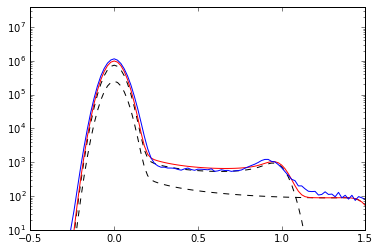

In [288]:
S_no = I_no > 0.5
sigma_fit_no, L_fit_no, nphotons_fit_list_no, noise_sigma_fit_no = fit_and_plot_no_gas(I_no, H_no, S_no)

[4302152.0134925256, 3005688.7241835678] [9766975.5678010825, -4535410.1668990348]


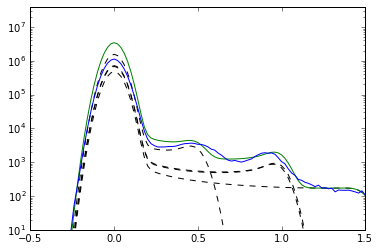

In [286]:
I_N2 = I_no
S_N2 = I_N2 > -0.5
#x = fit_and_plot_N2(I=I_N2, H=H_N2, S=S_N2, sigma_fit=sigma_fit,
#                    L0=L_fit_no, nphotons10=2122717, nphotonsN20=7933926, noise_sigma0=noise_sigma_fit_no)
#L_fit_N2, nphotons1_fit_N2, nphotonsN_fit_N2, noise_sigma_fit_N2 = x
x = fit_and_plot_N2(I=I_N2, H=H_N2, S=S_N2, nphotons00=2122717, nphotonsN0=7933926, sigma=sigma_fit_no,
                    L=L_fit_no, noise_sigma=noise_sigma_fit_no, photon_energy=1., N=2)

